# Esercitazione 7
### Laboratorio di Simulazione Numerica

Il materiale dell'esercitazione sette di LSN è interamente raccolto nella cartella `Lab_07/Code`. Essa contiene quattro sotto-cartelle, dai nomi `7.1, 7.2, 7.3, 7.4`, corrispondenti alle quattro consegne dell'esercizio.

Ognuna di queste cartelle contiene una copia del programma `Monte_Carlo_NVT.cpp/h` e i risultati relativi all'esecuzione dello specifico compito.

---

In questa esercitazione, per eseguire in modo più comodo i programmi, ho scritto uno script Python, che si trova nella descrizione dell'esercizio 7.1, con il quale ho reso automatici alcuni comandi da terminale. Per questa ragione, sconsiglio fortemente l'esecuzione del notebook: il processo potrebbe richiedere molto tempo.

---

La struttura del Jupyter Notebook è la seguente:
- 7.0 caricamento dei pacchetti e introduzione;
- 7.1 equilibrazione della simulazione, analisi delle funzioni di autocorrelazione e stima del numero efficace di blocchi;
- 7.2 funzione di distribuzione radiale $g(r)$;
- 7.3 aggiunta di $g(r)$ nel codice `MolDyn_NVE.cpp/h`
- 7.4 simulazione delle fasi solida, liquida e gassosa dell'Argon: stima di $g(r)$ e _banchmarking_ dei risultati ottenuti con `Monte_Carlo_NVT.cpp/h` e `MolDyn_NVE.cpp/h`.

## 7.0 - Caricamento pacchetti e introduzione

In questa esercitazione affrontiamo un problema simile a quello proposto nell'esercitazione 4, utilizzando un approccio diverso e mettendo a confronto i risultati ottenuti con i due metodi. In questo caso, le mosse (`Move()`) a cui il sistema termodinamico è sottoposto sono tipiche delle Catene di Markov, implementate sotto forma di passi estratti in modo uniforme tra zero e $\delta$ attorno al punto in cui si trova la particella. 

Questa volta, oltre a cambiare approccio, ci preoccupiamo del fenomeno dell'autoccorrelazione che è intrinsecamente presente in simulazioni in cui i dati sono ottenuti in maniera sequenziale. Nel farlo, cerchiamo di capire quale sia la dimensione più efficace di dei blocchi di dati su cui effettuare le misure che contribuiscono alla stima delle grandezze tramite metodo di blocking.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import tqdm as tqdm
from IPython.display import clear_output

sns.set_theme(font_scale=1.7, style='whitegrid')

## 7.1 - Equilibrazione, funzione di autocorrelazione, analisi dei blocchi

In questa prima parte dell'esercizio ho aggiunto al codice `MonteCarlo_NVT.cpp/h` il metodo `Equilibrate_system(int Nequi)`, che implementa `Nequi` mosse di metropolis che non vengono coinvolte nella stima delle grandezze (il blocking parte al termine della fase di equilibrazione). Con lo script seguente vengono eseguiti tre lanci del programma, ciascuno dei quali corrispondente ad una specifica delle tre fasi termodinamiche in analisi. Per ciascuna delle tre run ho predisposto `Nequi=10'000` passi di equilibrazione e `Nstep=50'000` passi per blocco con un totale di `Nblks=10`. In totale stiamo analizzando $5\times 10^5$ misure. 

---

Con l'intenzione di trovare un passo di metropolis tale che l'accettazione in ogni blocco sia quanto più possibile vicina al 50% ho svolto alcuni tentativi. Per gli stati solido e liquido sono riuscito a trovare un valore tale da soddisfare la richiesta. Per quanto riguarda lo stato gassoso, anche impostando come passo circa la metà del lato del box analizzato non sono riuscito ad ottenere accettazioni migliori del 62%. Le scelte definitive, con le quali ho eseguito il programma nelle celle seguenti sono:
- fase solida $\delta_s = 0.11$
- fase liquida $\delta_l = 0.2$
- fase gassosa $\delta_g = 5.0$

In [2]:
path = "Code/7.1/"
istant = []

ist_files = ["output_solid.dat", "output_liquid.dat", "output_gas.dat"]
inp_files = ["input.solid", "input.liquid", "input.gas"]
phase = ['Solido', 'Liquido', "Gas"]
colors = ['orange', 'red', 'purple']

In [47]:
print('-----------------------------------------------------')
print("Stiamo eseguendo 500'000 passi di MCMC")
print("Questo avverrà per tre volte")
print("Il processo potrebbe richiedere molto tempo.")
print("-----------------------------------------------------")

for i in range(3):
    print("Esecuzione del programma per lo stato " + phase[i])
    subprocess.call("cp " + str(inp_files[i]) + " input.dat", cwd = path, shell=True)
    subprocess.call("rm " + str(ist_files[i]), cwd = path, shell=True)
    subprocess.call("make clean", cwd = path, shell=True)
    subprocess.call("make", cwd = path, shell=True)
    subprocess.call("./Monte_Carlo_NVT.exe", cwd = path, shell=True)
    subprocess.call("cp istant_output.dat " + str(ist_files[i]), cwd = path, shell=True)
    
print("Fine dell'esecuzione!")

-----------------------------------------------------
Stiamo eseguendo 500'000 passi di MCMC
Questo avverrà per tre volte
Il processo potrebbe richiedere molto tempo.
-----------------------------------------------------
Esecuzione del programma per lo stato Solido
Esecuzione del programma per lo stato Liquido
Esecuzione del programma per lo stato Gas
Fine dell'esecuzione!


In [3]:
for i in range(3):
    istant.append(np.loadtxt(path+ist_files[i]))

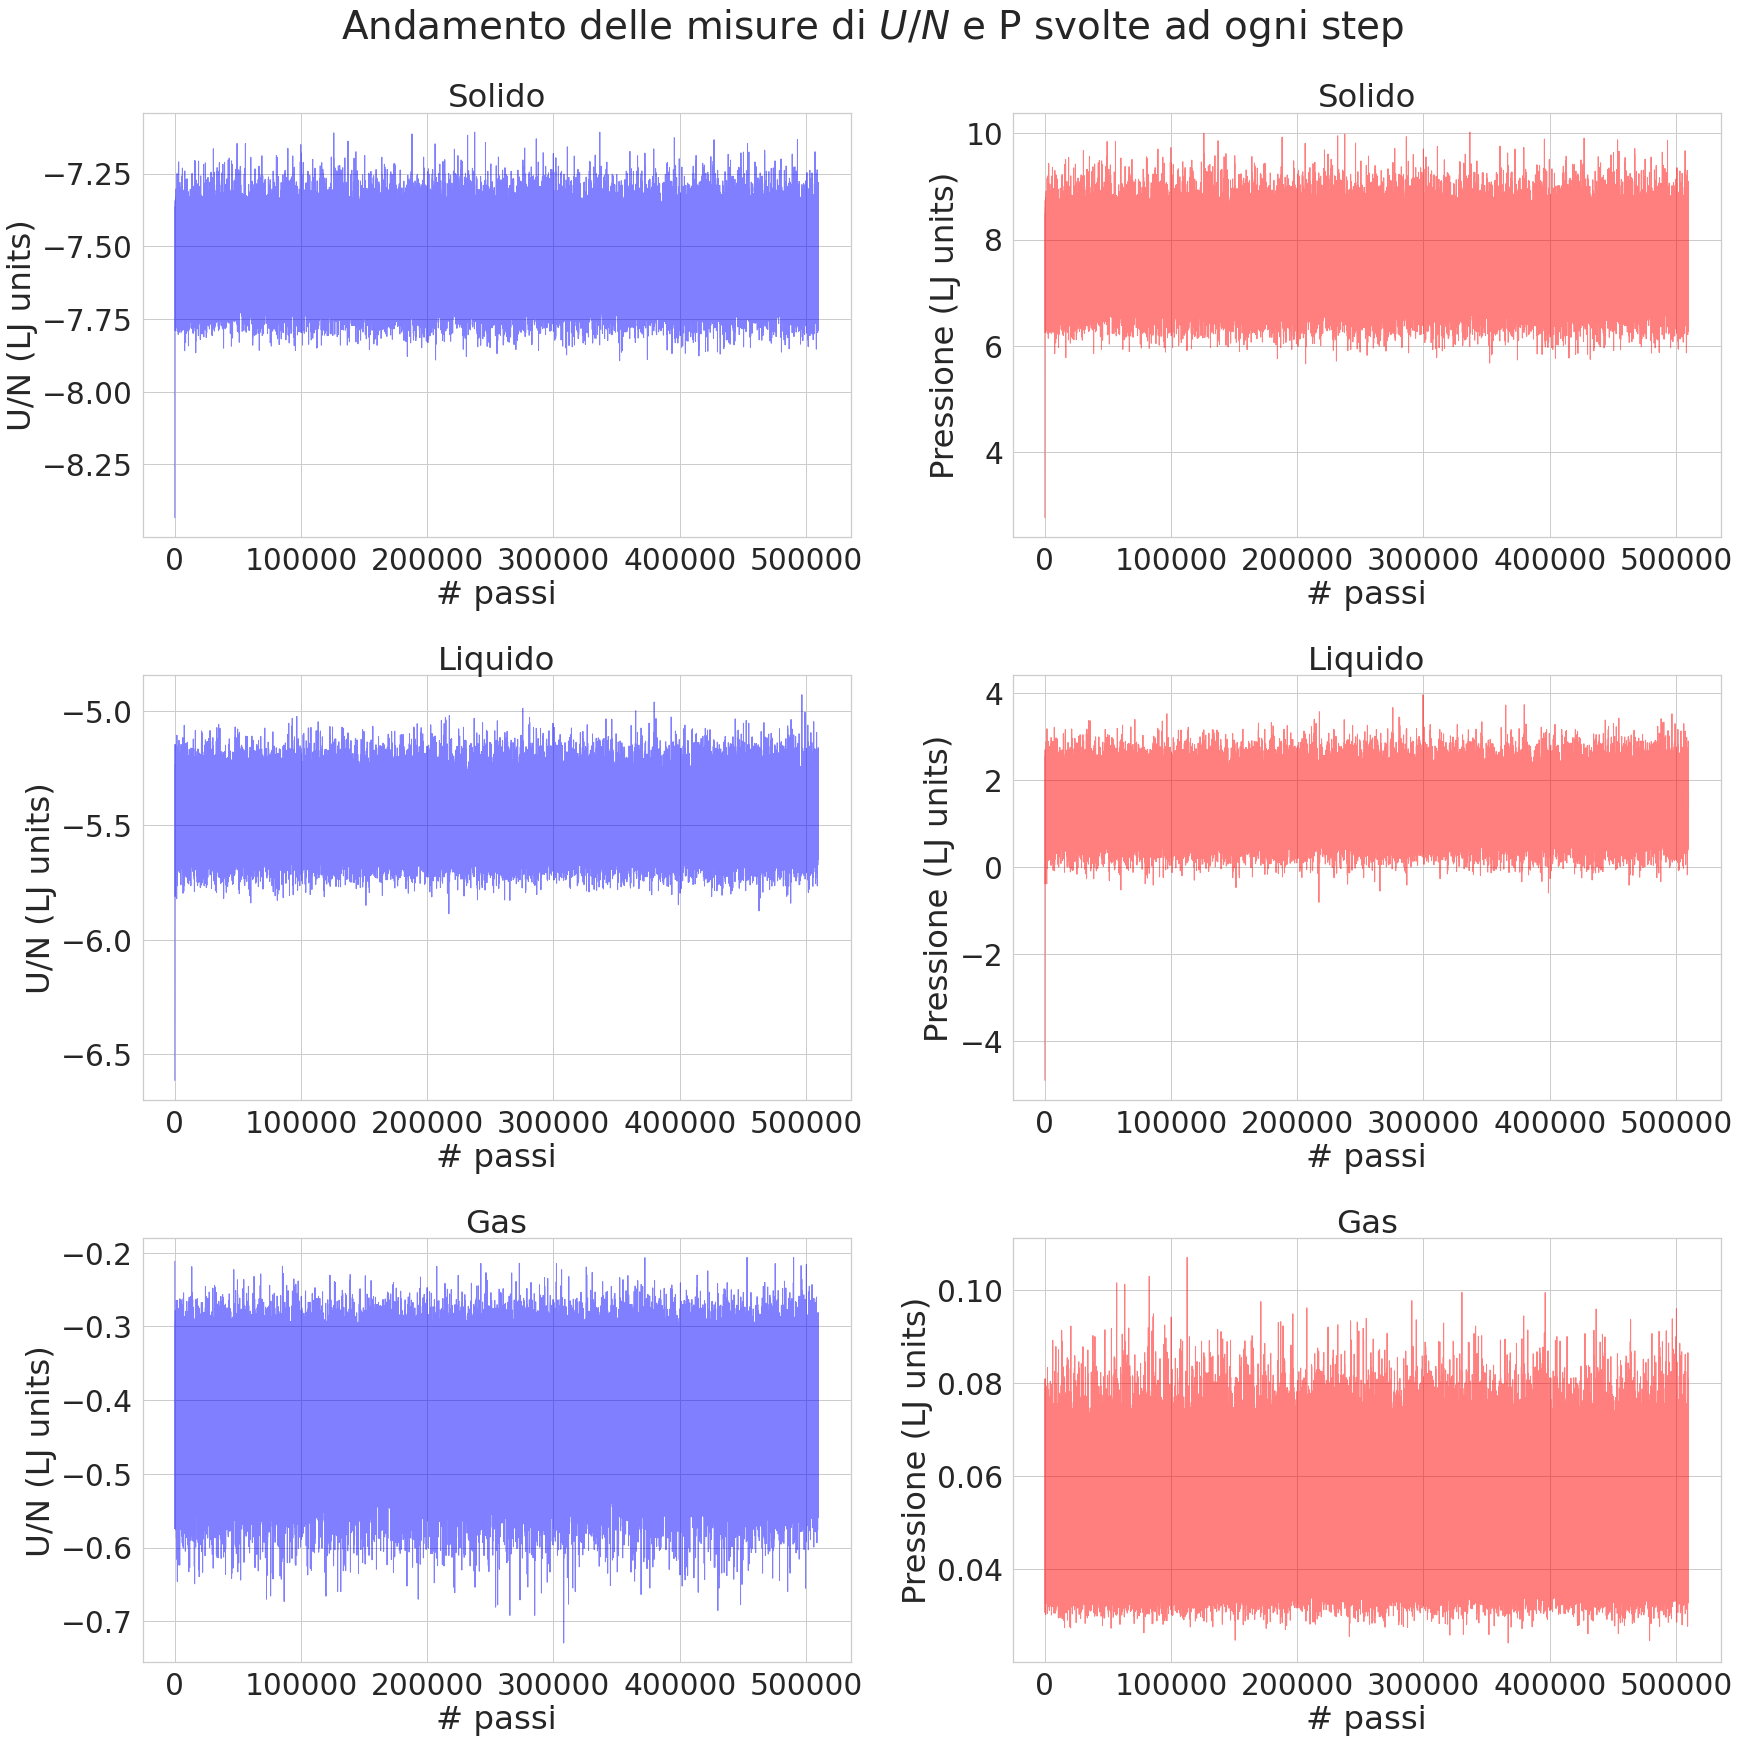

In [8]:
plt.figure(figsize=(25,25))
sns.set_theme(font_scale=2.7, style='whitegrid')

plt.suptitle('Andamento delle misure di $U/N$ e P svolte ad ogni step')

for i in range(0,6,2):
    
    plt.subplot(3,2,i+1)
    plt.title(phase[int(i/2)])
    plt.plot(istant[int(i/2)].T[0], linewidth=1, alpha=0.5, color='blue')
    plt.xlabel('# passi')
    plt.ylabel('U/N (LJ units)')
    
    plt.subplot(3,2,i+2)
    plt.title(phase[int(i/2)])
    plt.plot(istant[int(i/2)].T[2], linewidth=1, alpha=0.5, color='red')
    plt.xlabel('# passi')
    plt.ylabel('Pressione (LJ units)')

plt.tight_layout()    
plt.show()

Vogliamo adesso comprendere quale sia il giusto numero di blocchi da scegliere per far sì che i dati tra blocchi diversi siano tra loro quanto più scorrelati possibile. Dunque calcoliamo, a partire dai dati istantanei ottenuti, il valore delle funzioni di autocorrelazione dei dati di energia potenziale e pressione le tre fasi termodinamiche di interesse. Nella cella seguente implemento la funzione di autocorrelazione come segue: 

$$ AC(\tau) = \frac{ \frac{1}{t-\tau}\sum_{t'=0}^{t-\tau}x(t')x(t'+\tau) -\frac{1}{t-\tau}\sum_{t'=0}^{t-\tau} x(t') \times \sum_{t'=0}^{t-\tau} x(t'+\tau) }{\frac{1}{\tau} \sum_{t'=0}^t x^2(t') - \biggl( \frac{1}{\tau} \sum_{t'=0}^t x(t')\biggr)^2 } $$

In [23]:
N = len(istant[0].T[0])

In [95]:
AC_U = []
AC_P = []


npoints = 200

for i in range(3):
    print("Funzione di autocorrelazione, fase " + phase[i])
    ac_u = []
    ac_p = []
    for tau in tqdm.tqdm(range(npoints)):
        U_minus_tau = istant[i].T[0][:N - tau]
        P_minus_tau = istant[i].T[2][:N - tau]
        U_plus_tau = istant[i].T[0][tau:]
        P_plus_tau = istant[i].T[2][tau:]

        n = len(U_minus_tau)
        ac_u.append((sum(U_minus_tau * U_plus_tau)/n - sum(U_minus_tau) / 
                     n * sum(U_plus_tau) / n)/np.std(istant[i].T[0])**2)
        ac_p.append((sum(P_minus_tau * P_plus_tau)/n - sum(P_minus_tau) / 
                    n * sum(P_plus_tau) / n)/np.std(istant[i].T[2])**2)
        
    # i-th element is a list containing the values of AC function for i-th phase 
    AC_U.append(ac_u)
    AC_P.append(ac_p)


  0%|          | 0/200 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Solido


  0%|          | 0/200 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Liquido


  0%|          | 0/200 [00:00<?, ?it/s]

Funzione di autocorrelazione, fase Gas


100%|██████████| 200/200 [01:51<00:00,  1.79it/s]


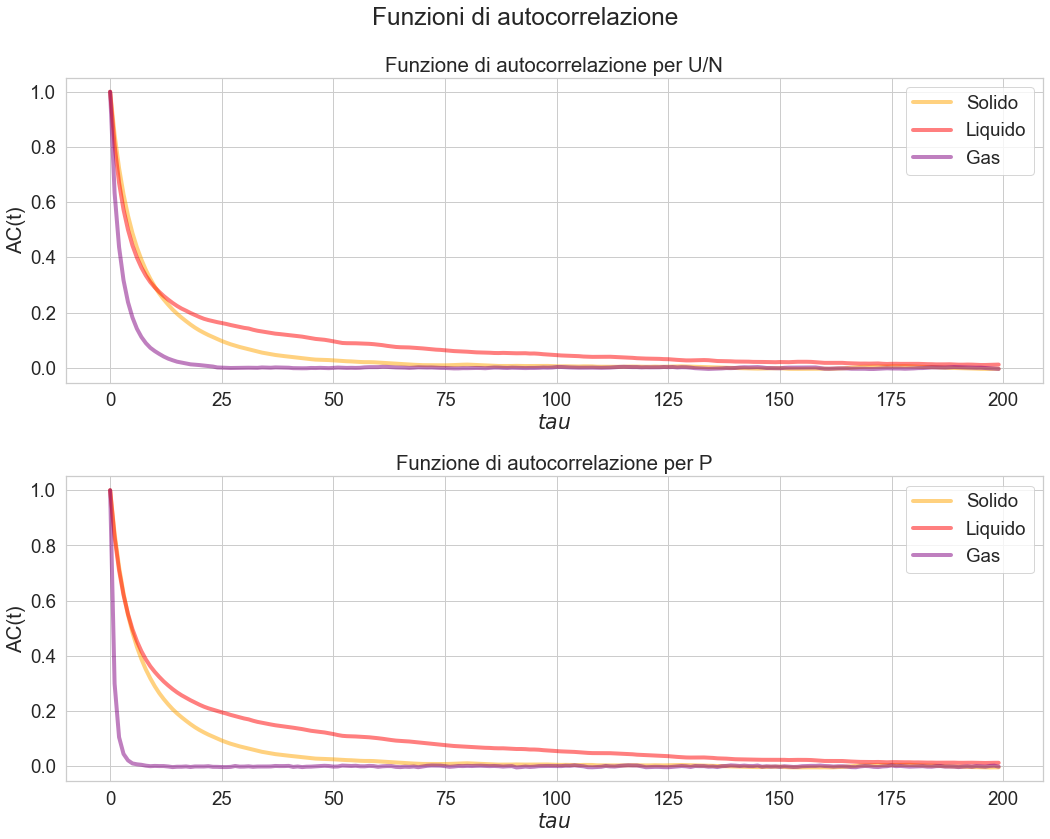

In [114]:
plt.figure(figsize=(15,12))
plt.suptitle("Funzioni di autocorrelazione")

plt.subplot(2,1,1)
plt.title("Funzione di autocorrelazione per U/N")
for i in range(3):
    plt.plot(AC_U[i], color=colors[i], linewidth=4, alpha=0.5, label=phase[i])
    plt.legend()
    plt.xlabel('$tau$')
    plt.ylabel('AC(t)')
    
plt.subplot(2,1,2)
plt.title("Funzione di autocorrelazione per P")
for i in range(3):
    plt.plot(AC_P[i], color=colors[i], linewidth=4, alpha=0.5, label=phase[i])
    plt.legend()
    plt.xlabel('$tau$')
    plt.ylabel('AC(t)')

plt.tight_layout()    
plt.show()

In [10]:
def error(AV,AV2,n):  
    if n==0:
        return 0
    else:
        return np.sqrt((AV2[n] - AV[n]**2)/n)

def blocking(r,L):   
    
    M = len(r)
    N=int(M/L)
    x = np.arange(N)
    ave = np.zeros(N)
    av2 = np.zeros(N)
    sum_prog = np.zeros(N)
    su2_prog = np.zeros(N)
    err_prog = np.zeros(N)

    for i in range(N):
        sum = 0
        for j in range(L):
            k = j+i*L
            sum += r[k]
        ave[i] = sum/L       # r_i 
        av2[i] = (ave[i])**2 # (r_i)^2 

    for i in range(N):
        for j in range(i+1):
            sum_prog[i] += ave[j] # SUM_{j=0,i} r_j
            su2_prog[i] += av2[j] # SUM_{j=0,i} (r_j)^2
        sum_prog[i]/=(i+1) # Cumulative average
        su2_prog[i]/=(i+1) # Cumulative square average
        err_prog[i] = error(sum_prog,su2_prog,i) # Statistical uncertainty
        
    return err_prog[len(err_prog)-1]  #stampo l'ultimo errore del blocking poichè restituisce un vettorone

In [50]:
%%time

Nequi = 10000

L = np.arange(10,5000,20)
ERR_U = []
ERR_P = []

for iphase in range(3): 
    
    small_u = istant[iphase].T[0][Nequi: 210000]          #escludo la fase di equilibrazione
    small_p = istant[iphase].T[2][Nequi: 210000]          #tronco a 200'000 il campione

    print("Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato " + phase[iphase])
    err_u = []
    err_p = []
    for i in tqdm.tqdm(range(len(L))):
        err_u.append(blocking(small_u, L[i]))
        err_p.append(blocking(small_p, L[i]))
    
    ERR_U.append(err_u)
    ERR_P.append(err_p)

  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Solido


  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Liquido


  0%|                                                                       | 0/250 [00:00<?, ?it/s]

Calcolo dell'errore sull'ultimo blocco nel range L:[10,5000] per lo stato Gas


100%|█████████████████████████████████████████████████████████████| 250/250 [10:07<00:00,  2.43s/it]

CPU times: user 30min 10s, sys: 700 ms, total: 30min 11s
Wall time: 30min 13s


In [32]:
sns.set_theme(font_scale=1.7, style='whitegrid')

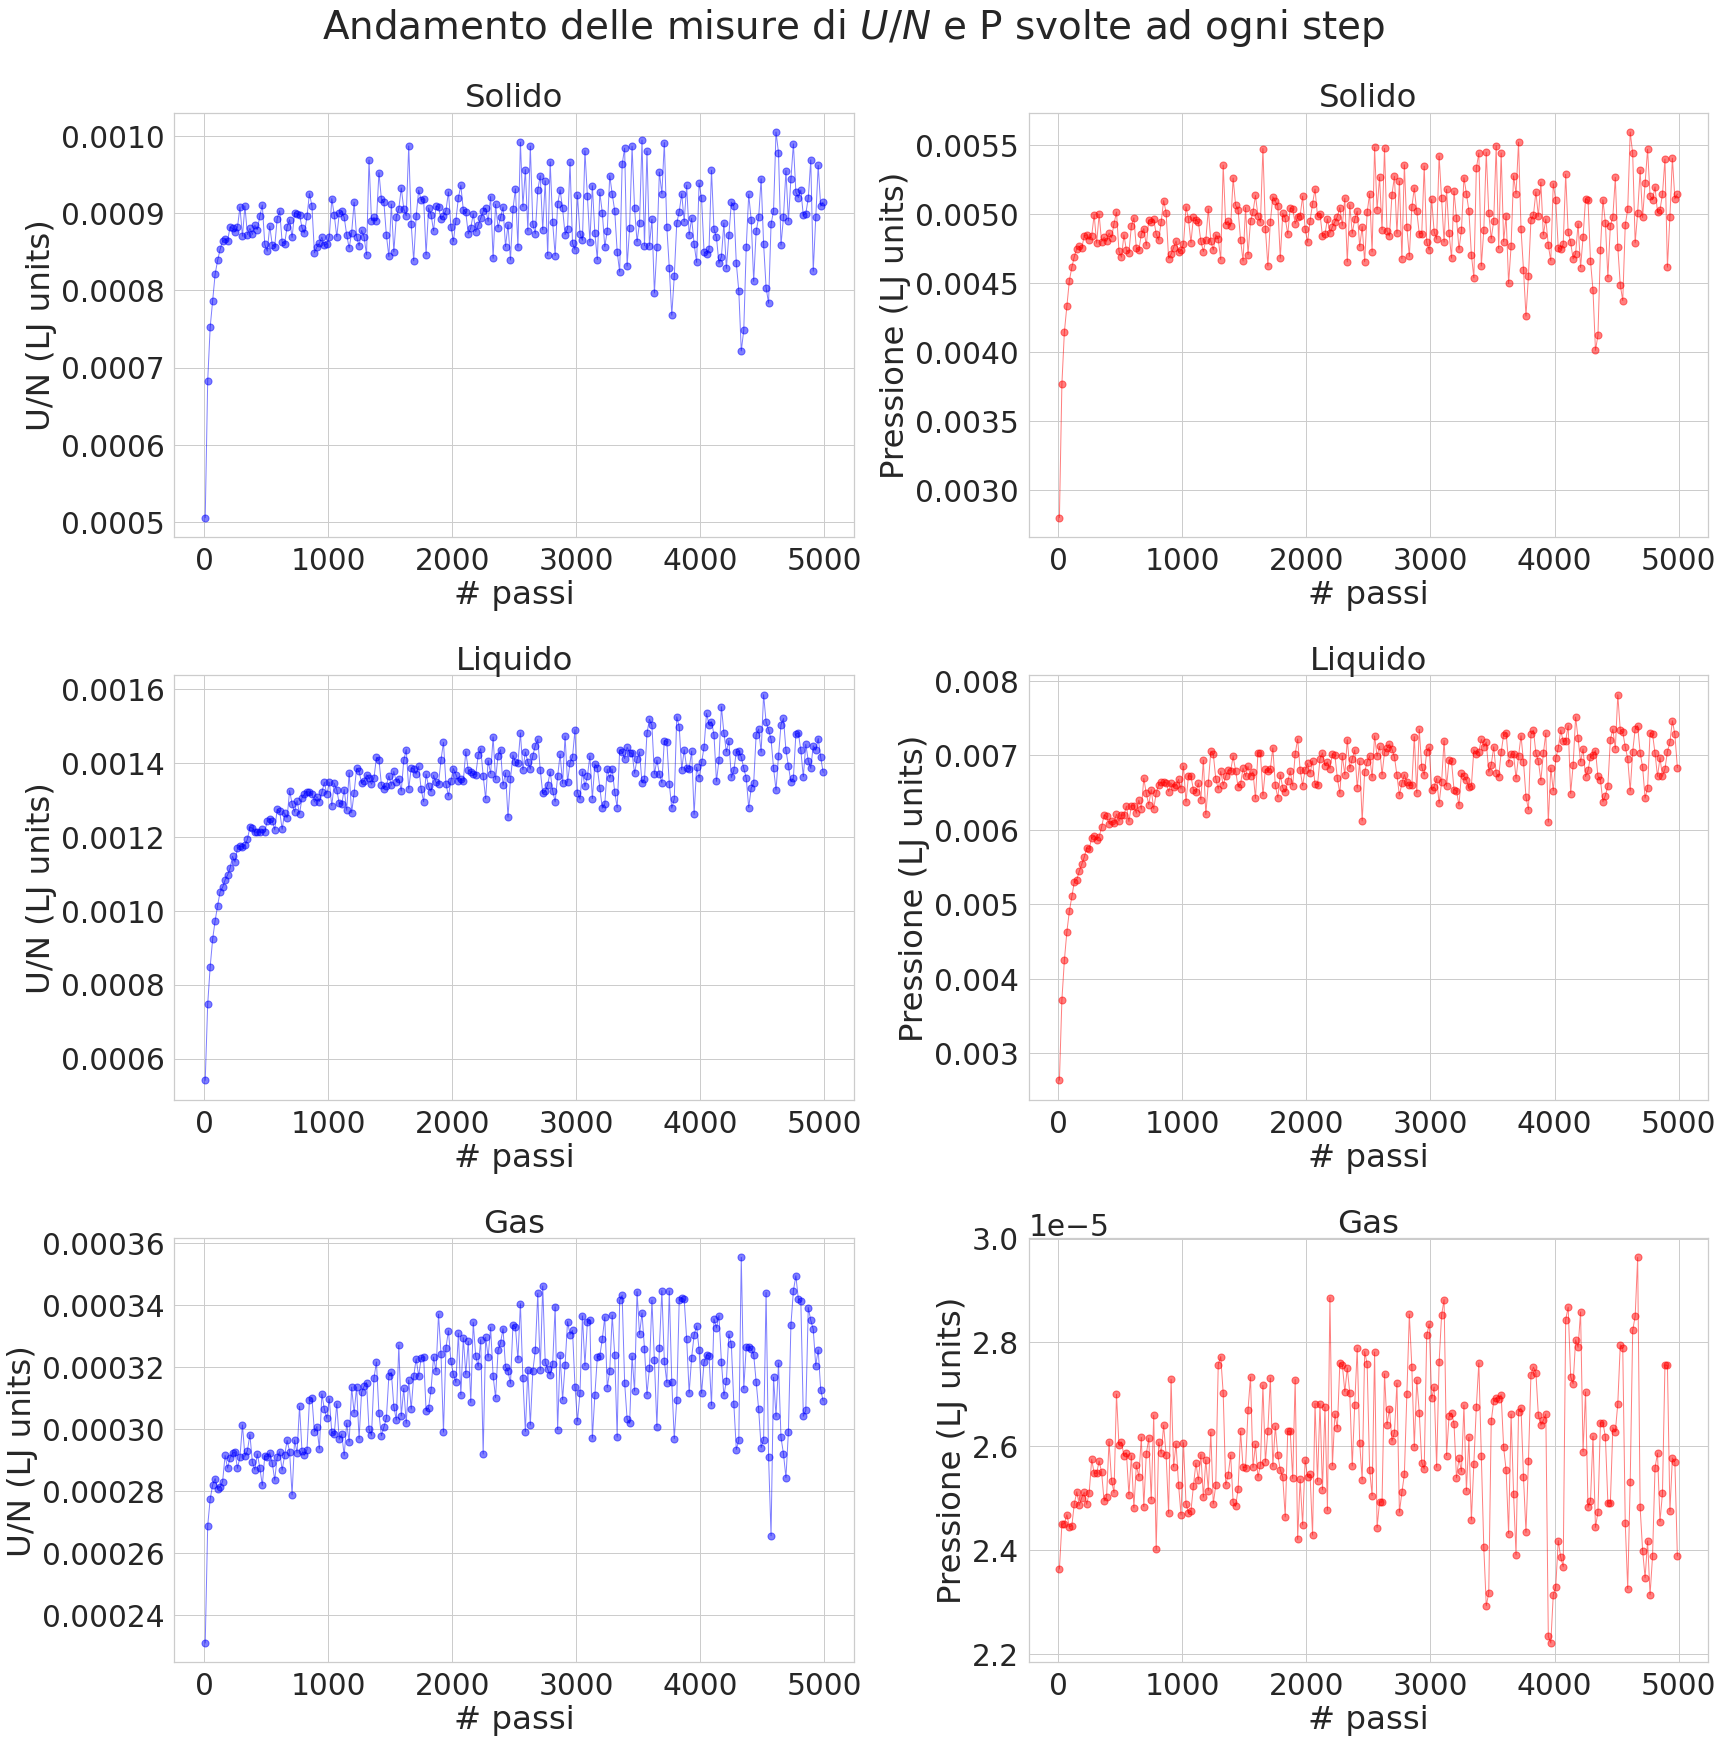

In [51]:
plt.figure(figsize=(25,25))
sns.set_theme(font_scale=2.7, style='whitegrid')

plt.suptitle('Andamento delle misure di $U/N$ e P svolte ad ogni step')

for i in range(0,6,2):
    
    plt.subplot(3,2,i+1)
    plt.title(phase[int(i/2)])
    plt.scatter(L, ERR_U[int(i/2)], s=50, alpha=0.5, color='blue')
    plt.plot(L, ERR_U[int(i/2)], linewidth=1, alpha=0.5, color='blue')
    plt.xlabel('# passi')
    plt.ylabel('U/N (LJ units)')
    
    plt.subplot(3,2,i+2)
    plt.title(phase[int(i/2)])
    plt.scatter(L, ERR_P[int(i/2)], s=50, alpha=0.5, color='red')
    plt.plot(L, ERR_P[int(i/2)], linewidth=1, alpha=0.5, color='red')
    plt.xlabel('# passi')
    plt.ylabel('Pressione (LJ units)')

plt.tight_layout()    
plt.show()

In [162]:
gofr_solid  = np.loadtxt('Results/gofr_NVT_solid.0')
gofr_liquid = np.loadtxt('Results/gofr_NVT_liquid.0')
gofr_gas    = np.loadtxt('Results/gofr_NVT_gas.0')

In [163]:
NVE_solid = np.loadtxt("Results/gofr_NVE_solid.dat")
NVE_liquid = np.loadtxt("Results/gofr_NVE_liquid.dat")
NVE_gas = np.loadtxt("Results/gofr_NVE_gas.dat")

In [164]:
hist_vals_sol = []
hist_errs_sol = []
hist_vals_liq = []
hist_errs_liq = []
hist_vals_gas = []
hist_errs_gas = []


nbins = 100
nprop = 4
binsize = ()

r_liq = gofr_liquid.T[0]
r_sol = gofr_solid.T[0]
r_gas = gofr_gas.T[0]

for i in range(8,int(2*(nbins+nprop)),2):
    hist_vals_sol.append(NVE_solid.T[i][9])
    hist_errs_sol.append(NVE_solid.T[i+1][9])
    hist_vals_liq.append(NVE_liquid.T[i][9])
    hist_errs_liq.append(NVE_liquid.T[i+1][9])
    hist_vals_gas.append(NVE_gas.T[i][9])
    hist_errs_gas.append(NVE_gas.T[i+1][9])

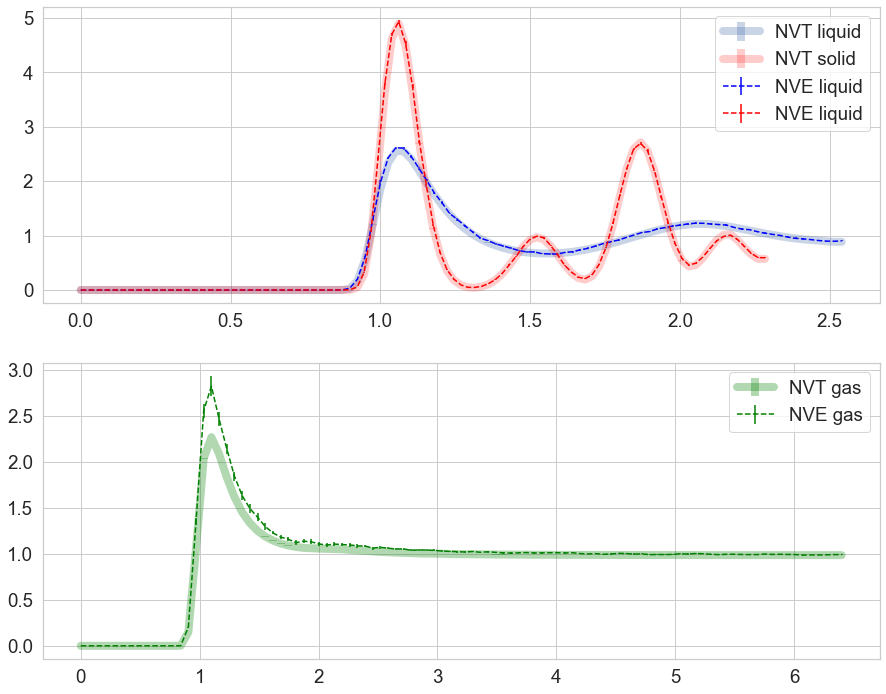

In [169]:
plt.figure(figsize=(15,12))
#plt.plot(hist_vals, color='red', linestyle='--')
plt.subplot(2,1,1)
plt.errorbar(gofr_liquid.T[0], gofr_liquid.T[1], yerr=gofr_liquid.T[2], linewidth=8, alpha=0.3, label='NVT liquid')
plt.errorbar(gofr_solid.T[0], gofr_solid.T[1], yerr=gofr_solid.T[2], color='red', alpha=0.2, linewidth=8, label='NVT solid')
plt.errorbar(r_liq, hist_vals_liq, yerr=hist_errs_liq, color='blue', linestyle='--', label='NVE liquid')
plt.errorbar(r_sol, hist_vals_sol, yerr=hist_errs_sol, color='red', linestyle='--', label='NVE liquid')
plt.legend()

plt.subplot(2,1,2)
plt.errorbar(gofr_gas.T[0], gofr_gas.T[1], yerr=gofr_gas.T[2],color='green', linewidth=8, alpha=0.3, label='NVT gas')
plt.errorbar(r_gas, hist_vals_gas, yerr=hist_errs_gas, color='green', linestyle='--', label='NVE gas')
plt.legend()

plt.show()